# Bayesianness

Importing the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import minimize

In [2]:
%matplotlib notebook

Defining our model and distributions we intend to use.

In [3]:
def UnitRange(x, xmin=-np.inf, xmax=np.inf):
    if (xmin == -np.inf) and (xmax == np.inf):
        print('Please input at least one bound')
    else:
        x = np.array(x)
        return ((x > xmin) & (x < xmax)).astype(int)

In [4]:
def Model(x, m, c):
    return m*x + c

def Uniform(x, xmin, xmax):
    return UnitRange(x, xmin, xmax)/(xmax-xmin)

def Gaussian(x, μ, σ):
    return (2*np.pi*σ**2)**-0.5*np.exp(-0.5*((x-μ)/σ)**2)

def lnGaussian(x, μ, σ):
    return -0.5*(np.log(2*np.pi*σ**2) + ((x-μ)/σ)**2)

Defining our Prior and Likelihood function and hence determining the Posterior

In [5]:
def lnPrior(Params):
    m, c = Params
    Prior = 0
    mPrior = Gaussian(m, 2, 1)
    if mPrior > 0:
        Prior += np.log(mPrior)
    cPrior = UnitRange(c, -10, 10)
    if cPrior > 0:
        Prior += np.log(cPrior)
    
    return Prior

In [6]:
#Assuming a Gaussian distribution
def Likelihood(Params, x, y, yError):
    model = Model(x, *Params)
    σ = (yError)**-0.5
    
    return Gaussian(y, model, σ)

def lnLikelihood(Params, x, y, yError):  
    model = Model(x, *Params)
    σ = (yError)**-0.5
    
    return lnGaussian(y, model, σ)

In [7]:
def MinuslnPosterior(Params, x, y, yError, Evidence=1):
    running_total = 0
    for n in range(len(x)):
        running_total += -lnLikelihood(Params, x[n], y[n], yError[n])
    running_total += lnPrior(Params) - np.log(Evidence)
    
    return running_total

Creates a random set of data with normally distributed noise and a uniformly distributed error between 0 and 1

In [8]:
SetSeed = True

if SetSeed:
    Seed = 923114
    np.random.seed(Seed)

x = np.random.randn(20)
m, c = 2, 3
Noise = np.random.randn(20)
y = Model(x, m, c) + Noise
yError = np.random.random(20)

This minimises each of the parameters in the negative log likelihood function. This gives us the "Best fit parameters" for this data. The standard deviation is calculated by taking the square root of the diagonal elements of the inverse Hessian matrix (i.e. Covariance Matrix)

In [9]:
x0 = [0, 0]
Minimising = minimize(MinuslnPosterior, x0, args=(x, y, yError, 1))

if Minimising.success:
    Params = Minimising.x
    ParamsError = np.sqrt((np.diag(Minimising.hess_inv)))
    print(f'The fitted parameters are m = {round(Params[0], 3)} ± {round(ParamsError[0], 3)}, '
          f'c = {round(Params[1], 3)} ± {round(ParamsError[1], 3)}, Cov = {round(Minimising.hess_inv[0][1], 3)}')
else:
    print('There was an error when minimising this function')

The fitted parameters are m = 2.165 ± 0.317, c = 3.565 ± 0.303, Cov = -0.01


An array of aribitrary numbers is created to plot the model with the calculated best fit parameters.

In [10]:
xOutput = np.linspace(min(x), max(x), 1000)
yOutput = Model(xOutput, Params[0], Params[1])
yOutput_true = Model(xOutput, m, c)

The Graph is plotted

<IPython.core.display.Javascript object>


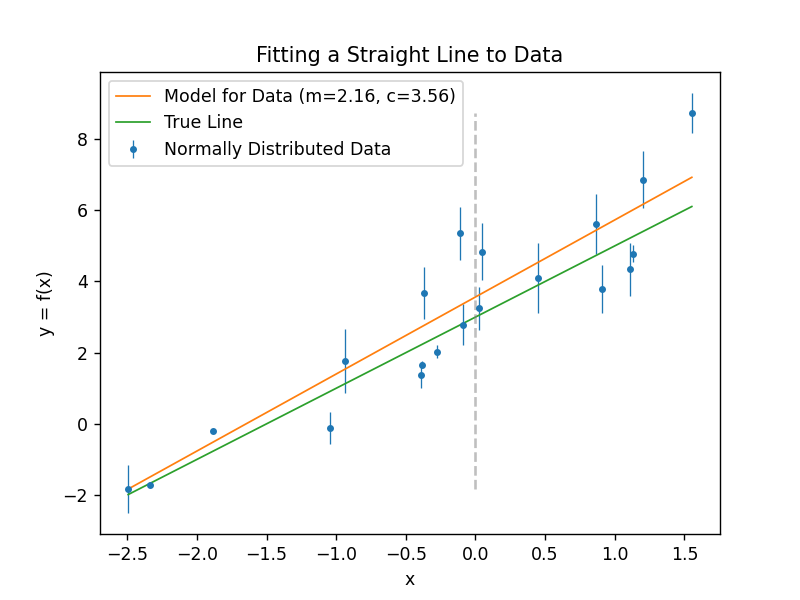

In [11]:
plt.figure()
plt.errorbar(x, y, yerr=yError, fmt='.', label='Normally Distributed Data', elinewidth=0.75)
plt.plot(xOutput, yOutput, label=f'Model for Data (m={round(Params[0], 2)}, c={round(Params[1], 2)})', linewidth=1)
plt.plot(xOutput, yOutput_true, label='True Line', linewidth=1)
plt.plot([0, 0], [min(y), max(y)], linestyle='--', color='grey', alpha=0.5)
plt.title('Fitting a Straight Line to Data')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend()
plt.show()

## Parameter Space

Parameter Space Plots.

In [12]:
def HeatMap(arr, x, y):
    plt.figure()
    plt.imshow(arr, cmap='gray', extent=[x[0], x[-1], y[0], y[-1]])
    plt.colorbar()
    plt.xlabel('m')
    plt.ylabel('c')
    plt.show()

In [13]:
Xm = np.linspace(-5, 10, 1000)
Xc = np.linspace(-15, 15, 1000)

### Prior Parameter Space

<IPython.core.display.Javascript object>


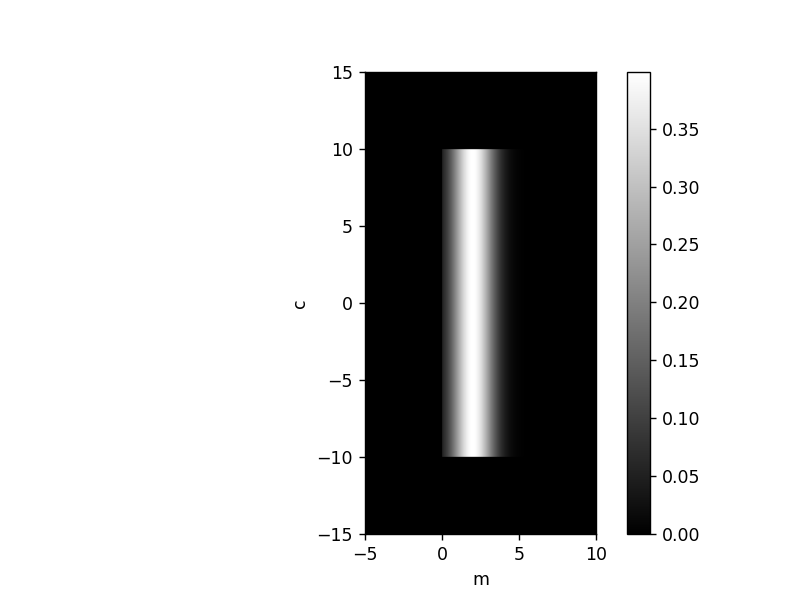

In [14]:
M = Gaussian(Xm, 2, 1)*UnitRange(Xm, 0)
C = UnitRange(Xc, -10, 10)
Test = np.outer(C, M)
HeatMap(np.array(Test), Xm, Xc)

### Likelihood Parameter Space

In [15]:
def ReLikelihood(Params):
    New = np.sum(lnLikelihood(Params, x, y, yError))
    return np.exp(New)

In [25]:
mValue = []
for n in range(len(Xm)):
    mValueInner = []
    for o in range(len(Xm)):
        mValueInner.append(ReLikelihood([Xm[o], np.flip(Xc)[n]]))
    mValue.append(mValueInner)

<IPython.core.display.Javascript object>


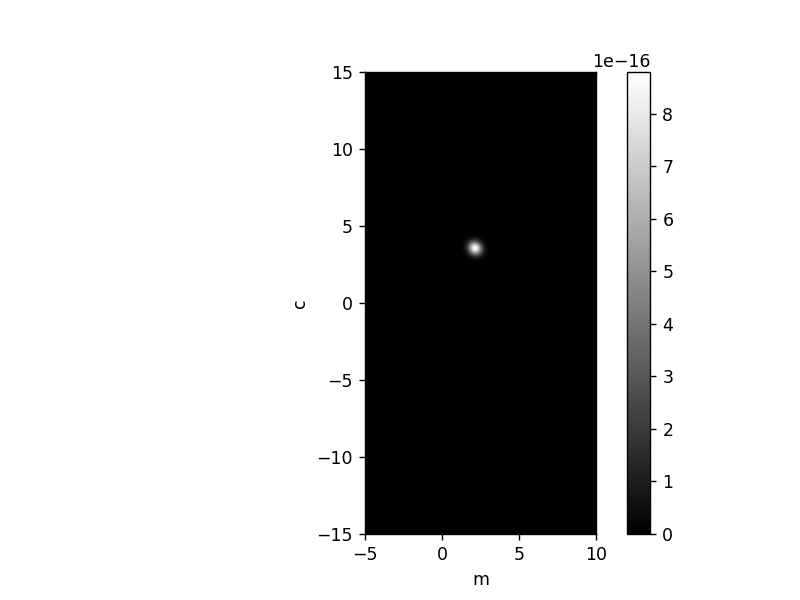

In [26]:
HeatMap(np.array(mValue), Xm, Xc)

### Posterior Parameter Space

#### Evidence

In [19]:
# Integral, Error = integrate.simpson(np.exp(lnLikelihood()+lnPrior()))

#### Posterior

In [20]:
Posterior = mValue*Test

<IPython.core.display.Javascript object>


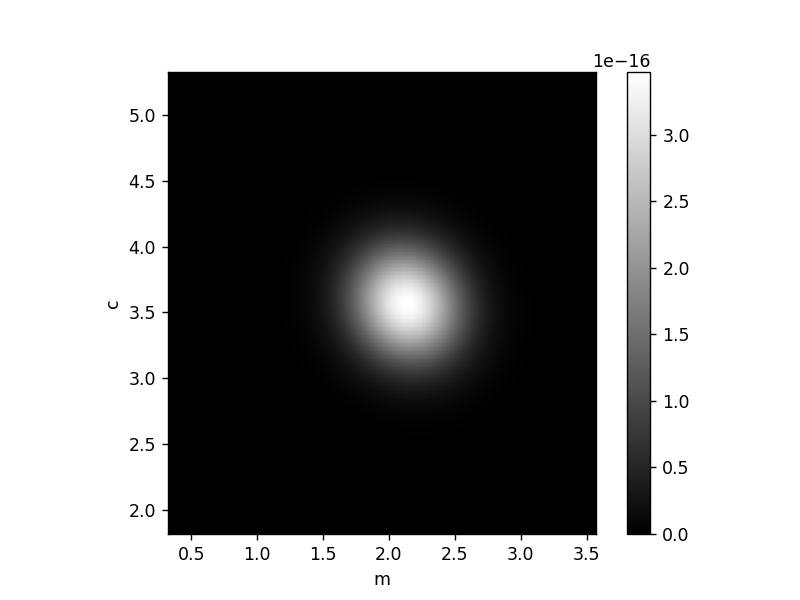

In [21]:
HeatMap(np.array(Posterior), Xm, Xc)